In [1]:
# prepare packages
import tensorflow as tf
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import os
import imageio
%matplotlib inline

In [2]:
# get data sets
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../MNIST_data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


# Network

In [3]:
# input placeholders
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

In [4]:
def generator(z, output_dim, reuse=False, initial_feature_size=512, alpha=0.2, is_training=True):
    with tf.variable_scope('generator', reuse=reuse):
        feature_map_size = initial_feature_size
        
        # 1. Fully connected layer (make 3x3x512)
        first_layer_units = 3 * 3 * feature_map_size
        x1 = tf.layers.dense(inputs=z, units=first_layer_units, activation=None, use_bias=True)
        # reshape as convolutional layer
        x1 = tf.reshape(tensor=x1, shape=[-1, 3, 3, feature_map_size])
        # add batch normalization
        x1 = tf.layers.batch_normalization(inputs=x1, training=is_training)
        # add reaky relu activation
        x1 = tf.maximum(alpha * x1, x1)
        
        # 2. convolutional layer (make 7x7x256)
        feature_map_size = feature_map_size // 2
        x2 = tf.layers.conv2d_transpose(inputs=x1, filters=feature_map_size, kernel_size=3, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(inputs=x2, training=is_training)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 3. convolutional layer (make 14x14x128)
        feature_map_size = feature_map_size // 2
        x3 = tf.layers.conv2d_transpose(inputs=x2, filters=feature_map_size, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(inputs=x3, training=is_training)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer, 28x28x1
        logits = tf.layers.conv2d_transpose(inputs=x3, filters=output_dim, kernel_size=5, strides=2, padding='same')
        out = tf.tanh(logits)
        
        return out

In [5]:
def discriminator(x, reuse=False, initial_filter_size=64, alpha=0.2, is_training=True):
    with tf.variable_scope('discriminator', reuse=reuse):
        # starting variable
        filters = initial_filter_size
        # Input layer is 28x28x1
        
        # make 14x14x64
        x1 = tf.layers.conv2d(inputs=x, filters=filters, kernel_size=5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        
        # make 7x7x128
        filters = filters * 2
        x2 = tf.layers.conv2d(inputs=x1, filters=filters, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(inputs=x2, training=is_training)
        x2 = tf.maximum(alpha * x2, x2)
        
        # make 4x4x256
        filters = filters * 2
        x3 = tf.layers.conv2d(inputs=x2, filters=filters, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(inputs=x3, training=is_training)
        x3 = tf.maximum(alpha * x3, x3)
        
        # flatten the layer
        flattened_layer = tf.reshape(tensor=x3, shape=[-1, 4*4*filters])
        logits = tf.layers.dense(inputs=flattened_layer, units=1)
        out = tf.sigmoid(logits)
        
        return out, logits

In [6]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

In [7]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

# Build

In [8]:
class DCGAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, real_size[2], alpha=0.2)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

In [9]:
# image save function
def save_generator_output(sess, input_z, out_channel_dim, img_str, title):
    cmap = 'gray'
    n_rows = 5
    n_cols = 5
    n_images = n_rows * n_cols
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    
    samples = sess.run(
        generator(input_z, out_channel_dim, reuse=True, is_training=False),
        feed_dict={input_z: example_z})
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5,5), sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples):
        ax.axis('off')
        ax.set_adjustable('box-forced')
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r', aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle(title)
    plt.savefig(img_str)
    plt.close(fig)

In [10]:
def view_samples(samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples):
        ax.axis('off')
        ax.set_adjustable('box-forced')
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r', aspect='equal')
    
    plt.subplots_adjust(wspace=0, hspace=0)

# Train

In [35]:
def train(net, epochs, batch_size, print_every=420):
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    losses = []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for ii in range(mnist.train.num_examples//batch_size):
                steps += 1
                
                # no need labels
                batch_x, _ = mnist.train.next_batch(batch_size)
                
                # Get images rescale to pass to D
                batch_images = batch_x.reshape(-1, 28, 28, 1)
                batch_images = batch_images*2 -1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})

        #if steps % print_every == 0:
            # At the end of each epoch, get the losses and print them out
            train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
            train_loss_g = net.g_loss.eval({net.input_z: batch_z})

            print("Epoch {}/{}...".format(e+1, epochs),
                  "Discriminator Loss: {:.4f}...".format(train_loss_d),
                  "Generator Loss: {:.4f}".format(train_loss_g))
            # Save losses to view after training
            losses.append((train_loss_d, train_loss_g))

            # save generated images on every epochs
            image_fn = './assets/DCGAN-MNIST-epoch-{:d}.png'.format(e)
            image_title = 'epoch {:d}'.format(e)
            save_generator_output(sess, net.input_z, 1, image_fn, image_title)
        
        # save trained generator's generation    
        samples = sess.run(
            generator(net.input_z, 1, reuse=True, is_training=False),
            feed_dict={net.input_z: sample_z})
        view_samples(samples, 6, 12, figsize=(10,5))
        
    return losses

# Hyperparameters

In [36]:
real_size = (28,28,1)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 1000
alpha = 0.2
beta1 = 0.5

# Create the network
net = DCGAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

In [37]:
assets_dir = './assets/'
if not os.path.isdir(assets_dir):
    os.mkdir(assets_dir)

Epoch 1/1000... Discriminator Loss: 0.5746... Generator Loss: 1.2499
Epoch 2/1000... Discriminator Loss: 0.6295... Generator Loss: 1.7227
Epoch 3/1000... Discriminator Loss: 0.7174... Generator Loss: 1.1193
Epoch 4/1000... Discriminator Loss: 0.8446... Generator Loss: 2.1684
Epoch 5/1000... Discriminator Loss: 0.9821... Generator Loss: 0.6330
Epoch 6/1000... Discriminator Loss: 0.6373... Generator Loss: 1.2407
Epoch 7/1000... Discriminator Loss: 0.7747... Generator Loss: 1.1906
Epoch 8/1000... Discriminator Loss: 0.5277... Generator Loss: 1.6370
Epoch 9/1000... Discriminator Loss: 0.5320... Generator Loss: 1.6233
Epoch 10/1000... Discriminator Loss: 1.9131... Generator Loss: 0.2550
Epoch 11/1000... Discriminator Loss: 0.5994... Generator Loss: 1.4363
Epoch 12/1000... Discriminator Loss: 0.6535... Generator Loss: 1.4787
Epoch 13/1000... Discriminator Loss: 1.1272... Generator Loss: 0.5900
Epoch 14/1000... Discriminator Loss: 0.8911... Generator Loss: 3.0230
Epoch 15/1000... Discriminato

Epoch 118/1000... Discriminator Loss: 0.5219... Generator Loss: 1.4831
Epoch 119/1000... Discriminator Loss: 0.2810... Generator Loss: 2.4033
Epoch 120/1000... Discriminator Loss: 0.2813... Generator Loss: 2.1247
Epoch 121/1000... Discriminator Loss: 0.7172... Generator Loss: 0.9752
Epoch 122/1000... Discriminator Loss: 0.7624... Generator Loss: 1.1075
Epoch 123/1000... Discriminator Loss: 0.5193... Generator Loss: 1.3426
Epoch 124/1000... Discriminator Loss: 0.2033... Generator Loss: 2.9387
Epoch 125/1000... Discriminator Loss: 0.6460... Generator Loss: 1.2703
Epoch 126/1000... Discriminator Loss: 0.6576... Generator Loss: 1.2094
Epoch 127/1000... Discriminator Loss: 0.8243... Generator Loss: 1.0471
Epoch 128/1000... Discriminator Loss: 0.8936... Generator Loss: 1.0189
Epoch 129/1000... Discriminator Loss: 0.5024... Generator Loss: 1.5094
Epoch 130/1000... Discriminator Loss: 0.5565... Generator Loss: 1.3240
Epoch 131/1000... Discriminator Loss: 0.3451... Generator Loss: 1.9962
Epoch 

Epoch 234/1000... Discriminator Loss: 0.5655... Generator Loss: 1.5209
Epoch 235/1000... Discriminator Loss: 0.2133... Generator Loss: 2.7591
Epoch 236/1000... Discriminator Loss: 0.3304... Generator Loss: 2.1662
Epoch 237/1000... Discriminator Loss: 0.4173... Generator Loss: 1.7294
Epoch 238/1000... Discriminator Loss: 0.4390... Generator Loss: 1.6617
Epoch 239/1000... Discriminator Loss: 0.1505... Generator Loss: 3.1532
Epoch 240/1000... Discriminator Loss: 0.2162... Generator Loss: 2.9080
Epoch 241/1000... Discriminator Loss: 0.6734... Generator Loss: 1.2935
Epoch 242/1000... Discriminator Loss: 0.2637... Generator Loss: 2.5173
Epoch 243/1000... Discriminator Loss: 0.4415... Generator Loss: 1.8827
Epoch 244/1000... Discriminator Loss: 0.4957... Generator Loss: 1.7276
Epoch 245/1000... Discriminator Loss: 0.3952... Generator Loss: 1.8406
Epoch 246/1000... Discriminator Loss: 1.0621... Generator Loss: 0.9520
Epoch 247/1000... Discriminator Loss: 0.4836... Generator Loss: 1.5892
Epoch 

Epoch 350/1000... Discriminator Loss: 0.0988... Generator Loss: 3.6683
Epoch 351/1000... Discriminator Loss: 0.1688... Generator Loss: 3.0902
Epoch 352/1000... Discriminator Loss: 0.1771... Generator Loss: 2.7184
Epoch 353/1000... Discriminator Loss: 0.6104... Generator Loss: 1.5877
Epoch 354/1000... Discriminator Loss: 0.2023... Generator Loss: 2.9402
Epoch 355/1000... Discriminator Loss: 0.4203... Generator Loss: 1.9803
Epoch 356/1000... Discriminator Loss: 0.5290... Generator Loss: 1.7426
Epoch 357/1000... Discriminator Loss: 0.3689... Generator Loss: 2.0427
Epoch 358/1000... Discriminator Loss: 0.3779... Generator Loss: 2.2722
Epoch 359/1000... Discriminator Loss: 0.4122... Generator Loss: 2.0813
Epoch 360/1000... Discriminator Loss: 0.2021... Generator Loss: 2.4863
Epoch 361/1000... Discriminator Loss: 0.2202... Generator Loss: 2.7604
Epoch 362/1000... Discriminator Loss: 0.3623... Generator Loss: 2.2502
Epoch 363/1000... Discriminator Loss: 0.4323... Generator Loss: 1.7769
Epoch 

Epoch 466/1000... Discriminator Loss: 0.3634... Generator Loss: 2.0817
Epoch 467/1000... Discriminator Loss: 0.5444... Generator Loss: 1.6757
Epoch 468/1000... Discriminator Loss: 0.6511... Generator Loss: 1.4817
Epoch 469/1000... Discriminator Loss: 0.4677... Generator Loss: 2.1293
Epoch 470/1000... Discriminator Loss: 0.0809... Generator Loss: 3.8100
Epoch 471/1000... Discriminator Loss: 0.3112... Generator Loss: 2.6731
Epoch 472/1000... Discriminator Loss: 0.5816... Generator Loss: 1.6937
Epoch 473/1000... Discriminator Loss: 0.1303... Generator Loss: 3.2486
Epoch 474/1000... Discriminator Loss: 0.1237... Generator Loss: 3.2245
Epoch 475/1000... Discriminator Loss: 0.7711... Generator Loss: 1.6405
Epoch 476/1000... Discriminator Loss: 0.1626... Generator Loss: 3.1565
Epoch 477/1000... Discriminator Loss: 0.5409... Generator Loss: 1.6439
Epoch 478/1000... Discriminator Loss: 0.3590... Generator Loss: 2.0253
Epoch 479/1000... Discriminator Loss: 0.3946... Generator Loss: 2.2101
Epoch 

Epoch 582/1000... Discriminator Loss: 0.3751... Generator Loss: 2.3550
Epoch 583/1000... Discriminator Loss: 0.2397... Generator Loss: 3.0519
Epoch 584/1000... Discriminator Loss: 0.1861... Generator Loss: 3.0323
Epoch 585/1000... Discriminator Loss: 0.2769... Generator Loss: 2.6693
Epoch 586/1000... Discriminator Loss: 0.4818... Generator Loss: 1.8797
Epoch 587/1000... Discriminator Loss: 0.4746... Generator Loss: 1.9490
Epoch 588/1000... Discriminator Loss: 0.2740... Generator Loss: 2.5485
Epoch 589/1000... Discriminator Loss: 0.2544... Generator Loss: 2.5533
Epoch 590/1000... Discriminator Loss: 0.3361... Generator Loss: 2.3998
Epoch 591/1000... Discriminator Loss: 0.2512... Generator Loss: 2.5138
Epoch 592/1000... Discriminator Loss: 0.3047... Generator Loss: 2.3127
Epoch 593/1000... Discriminator Loss: 0.1753... Generator Loss: 3.1378
Epoch 594/1000... Discriminator Loss: 0.2245... Generator Loss: 2.8448
Epoch 595/1000... Discriminator Loss: 0.3530... Generator Loss: 2.1885
Epoch 

Epoch 698/1000... Discriminator Loss: 0.1167... Generator Loss: 3.4449
Epoch 699/1000... Discriminator Loss: 0.2036... Generator Loss: 3.1550
Epoch 700/1000... Discriminator Loss: 0.4073... Generator Loss: 2.4994
Epoch 701/1000... Discriminator Loss: 0.2657... Generator Loss: 2.5421
Epoch 702/1000... Discriminator Loss: 0.1245... Generator Loss: 3.6194
Epoch 703/1000... Discriminator Loss: 0.1031... Generator Loss: 3.9130
Epoch 704/1000... Discriminator Loss: 0.1061... Generator Loss: 4.4805
Epoch 705/1000... Discriminator Loss: 0.3951... Generator Loss: 2.1370
Epoch 706/1000... Discriminator Loss: 0.3137... Generator Loss: 2.4140
Epoch 707/1000... Discriminator Loss: 0.0760... Generator Loss: 4.2612
Epoch 708/1000... Discriminator Loss: 0.2490... Generator Loss: 2.8572
Epoch 709/1000... Discriminator Loss: 0.1696... Generator Loss: 3.4288
Epoch 710/1000... Discriminator Loss: 0.3399... Generator Loss: 2.6061
Epoch 711/1000... Discriminator Loss: 0.2929... Generator Loss: 2.4228
Epoch 

Epoch 814/1000... Discriminator Loss: 0.2773... Generator Loss: 2.9157
Epoch 815/1000... Discriminator Loss: 0.0919... Generator Loss: 3.9304
Epoch 816/1000... Discriminator Loss: 0.3364... Generator Loss: 2.3028
Epoch 817/1000... Discriminator Loss: 0.2331... Generator Loss: 2.8780
Epoch 818/1000... Discriminator Loss: 0.0715... Generator Loss: 4.4338
Epoch 819/1000... Discriminator Loss: 0.1682... Generator Loss: 3.5871
Epoch 820/1000... Discriminator Loss: 0.4966... Generator Loss: 2.1645
Epoch 821/1000... Discriminator Loss: 0.2012... Generator Loss: 3.3202
Epoch 822/1000... Discriminator Loss: 0.1106... Generator Loss: 3.9359
Epoch 823/1000... Discriminator Loss: 0.1763... Generator Loss: 3.5482
Epoch 824/1000... Discriminator Loss: 0.2447... Generator Loss: 3.0804
Epoch 825/1000... Discriminator Loss: 0.4185... Generator Loss: 2.3342
Epoch 826/1000... Discriminator Loss: 0.2084... Generator Loss: 3.2483
Epoch 827/1000... Discriminator Loss: 0.1071... Generator Loss: 3.8522
Epoch 

Epoch 930/1000... Discriminator Loss: 0.1852... Generator Loss: 3.1161
Epoch 931/1000... Discriminator Loss: 0.3131... Generator Loss: 2.6258
Epoch 932/1000... Discriminator Loss: 0.0971... Generator Loss: 4.0249
Epoch 933/1000... Discriminator Loss: 0.1290... Generator Loss: 3.6621
Epoch 934/1000... Discriminator Loss: 0.3289... Generator Loss: 2.6063
Epoch 935/1000... Discriminator Loss: 0.0670... Generator Loss: 5.1067
Epoch 936/1000... Discriminator Loss: 0.1945... Generator Loss: 3.3531
Epoch 937/1000... Discriminator Loss: 0.0676... Generator Loss: 4.7060
Epoch 938/1000... Discriminator Loss: 0.1416... Generator Loss: 3.6346
Epoch 939/1000... Discriminator Loss: 0.1673... Generator Loss: 3.4954
Epoch 940/1000... Discriminator Loss: 0.1087... Generator Loss: 3.7338
Epoch 941/1000... Discriminator Loss: 0.2951... Generator Loss: 2.7750
Epoch 942/1000... Discriminator Loss: 0.4450... Generator Loss: 2.2762
Epoch 943/1000... Discriminator Loss: 0.1339... Generator Loss: 3.8612
Epoch 

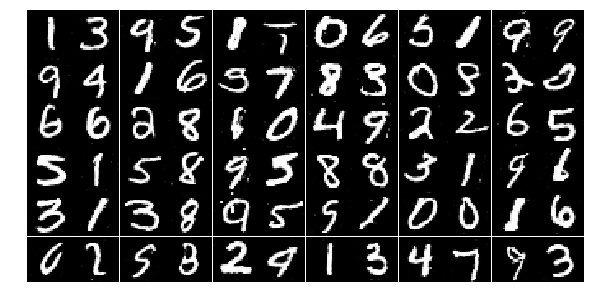

In [38]:
losses = train(net, epochs, batch_size)

In [15]:
# create animated gif from result images
images = []
for e in range(epochs):
    image_fn = './assets/DCGAN-MNIST-epoch-{:d}.png'.format(e)
    images.append( imageio.imread(image_fn) )
imageio.mimsave('./assets/DCGAN-MNIST-by-epochs.gif', images, fps=5)

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Training Losses")
plt.legend()

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator Loss')
plt.plot(losses.T[1], label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Training Losses")
plt.legend()